## Trabalho de Conclusão de Semestre - Redes Neurais e Algoritmos Genéticos
<p align = 'center'> <h2> Predições Climáticas: </h2></p>
<p align = 'center'> <h3> O uso de Redes Neurais para análise da influência de temperatura na superfície marítma em locais de ocorrência do fenômeno 'El Niño'</h3> </p>

#### Autores:
Alice Kageyama (220049), Haziel Sixto Baden Sanchez Hermoza (220065), Monyque Karoline de Paula Silva (220063), Pedro Thomazelli Ferreira (220058)

<hr>

In [1]:
# Importações:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError

# scikit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# captum
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

### Carregamento dos dados e pré-processamento

In [2]:
# Setup inicial:

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
ARQUIVO = 'dados/elnino.csv'

df = pd.read_csv(ARQUIVO, header=0)
df = df.drop(columns=['Observation', ' Date'])

# Removendo dados faltantes:
df = df[df != '.']
df.dropna(how='any', inplace=True)
df = df.astype(float)
df = df.reset_index(drop=True)

display(df)

Year   Month   Day   Latitude   Longitude   Zonal Winds   
0       93.0     5.0   9.0      -0.02     -109.96          -2.1  \
1       93.0     5.0  10.0      -0.02     -109.96          -3.4   
2       93.0     5.0  11.0      -0.02     -109.96          -3.8   
3       93.0     5.0  12.0      -0.02     -109.96          -3.0   
4       93.0     5.0  13.0      -0.02     -109.96          -4.5   
...      ...     ...   ...        ...         ...           ...   
93930   98.0     6.0  10.0       8.95     -140.33          -6.8   
93931   98.0     6.0  11.0       8.96     -140.33          -5.1   
93932   98.0     6.0  12.0       8.96     -140.32          -4.3   
93933   98.0     6.0  13.0       8.95     -140.34          -6.1   
93934   98.0     6.0  14.0       8.96     -140.33          -4.9   

        Meridional Winds   Humidity   Air Temp   Sea Surface Temp  
0                    2.1       81.2      26.80              27.02  
1                    1.4       84.2      26.95              26.91  
2                    2.2       84.9      26.98              26.78  
3                    1.5       86.9      26.93              26.74  
4                    1.9       87.6      27.01              26.82  
...                  ...        ...        ...                ...  
93930               -5.3       81.3      27.52              28.17  
93931               -0.4       94.1      26.04              28.14  
93932               -3.3       93.2      25.80              27.87  
93933               -4.8       81.3      27.17              27.93  
93934               -2.3       76.2      27.36              28.03  

[93935 rows x 10 columns]

In [3]:
# Definindo os dados de treino e teste:

FEATURES = [df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8]]
TARGET = [df.columns[9]]

indices = df.index

indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

x_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
x_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [4]:
# Normalização:

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(x_treino)
normalizador_y.fit(y_treino)

x_treino = normalizador_x.transform(x_treino)
y_treino = normalizador_y.transform(y_treino)
x_teste = normalizador_x.transform(x_teste)
y_teste = normalizador_y.transform(y_teste)

### Exploração dos dados

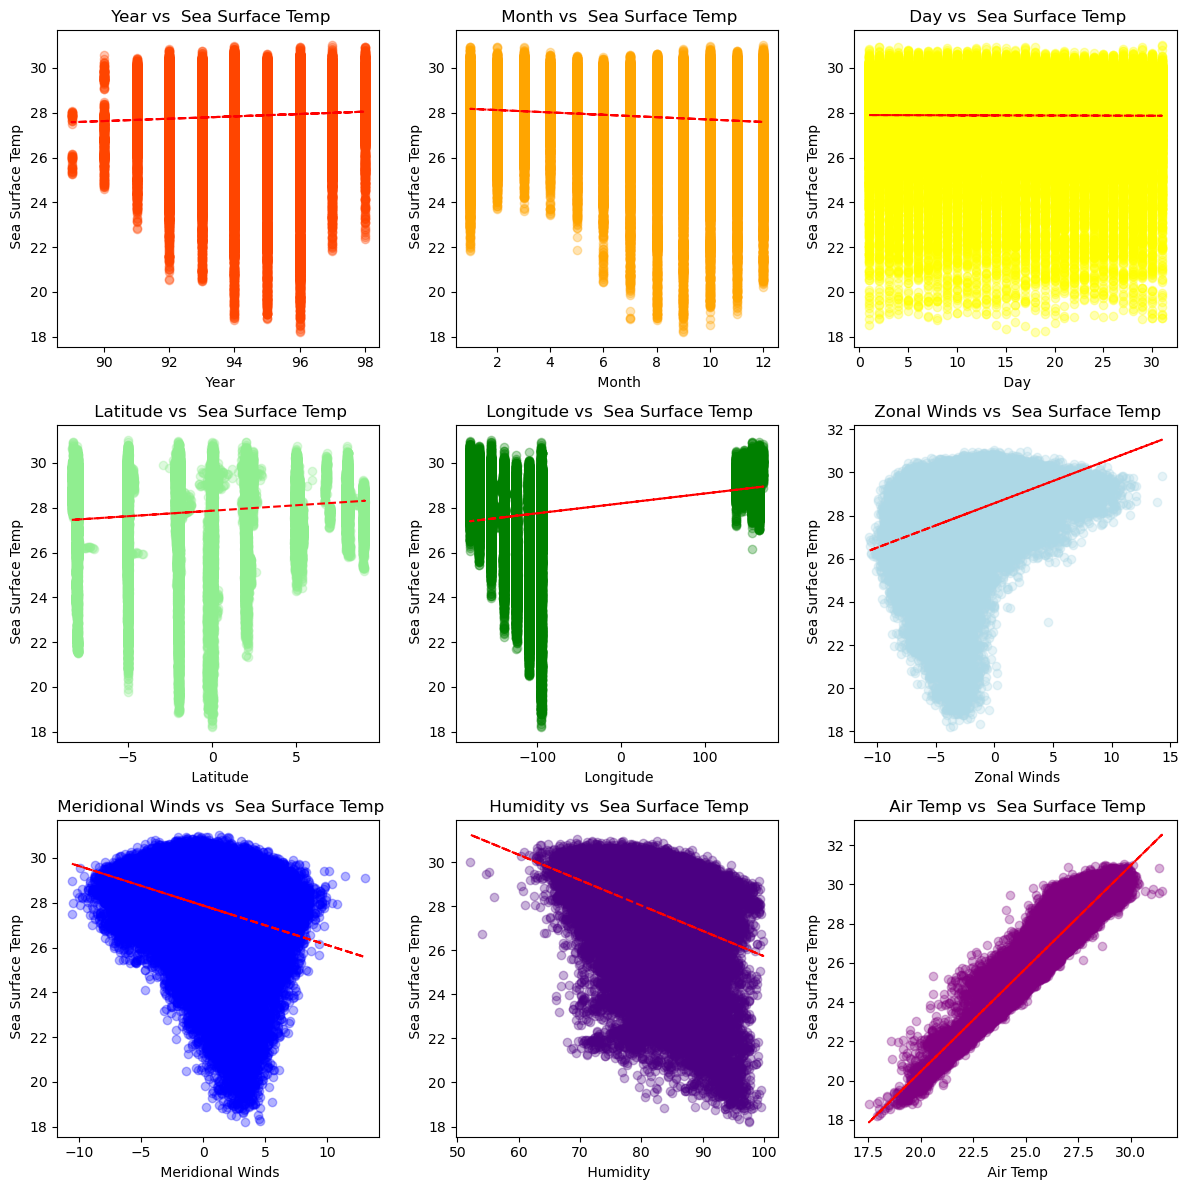

In [5]:
# Scatter plots para cada feature em relação ao target:

fig, axs = plt.subplots(3,3,figsize = (12,12))
axs = axs.flatten()
for (i, ax), cor in zip(enumerate(axs),['orangered', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'indigo', 'purple']):
    x = list(df[FEATURES[i]])
    y = list(df[TARGET[0]])
    
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)
    
    ax.scatter(x, y, color=cor, alpha=0.3)
    ax.plot(x, p(x), 'r--')
    
    ax.set_title(FEATURES[i] + ' vs ' + TARGET[0])
    ax.set_xlabel(FEATURES[i])
    ax.set_ylabel(TARGET[0])
    
plt.tight_layout()
plt.show()

In [6]:
# Matriz de covariância:

normalizador = MinMaxScaler()
normalizador.fit(df)
np_normalizado = normalizador.transform(df)
df_normalizado = pd.DataFrame(np_normalizado, columns = df.columns)

df_covariancia = df_normalizado.cov()

print('Matriz de covariância:')
df_covariancia

Matriz de covariância:


Year     Month       Day   Latitude   Longitude   
 Year              0.045729 -0.012611 -0.001035   0.001311   -0.002749  \
 Month            -0.012611  0.100274  0.001298  -0.000102   -0.001045   
 Day              -0.001035  0.001298  0.085982  -0.000131   -0.000216   
 Latitude          0.001311 -0.000102 -0.000131   0.075350    0.009758   
 Longitude        -0.002749 -0.001045 -0.000216   0.009758    0.135273   
 Zonal Winds       0.000770  0.002738  0.000202   0.004432    0.018345   
 Meridional Winds -0.002330  0.010759  0.000213  -0.003239   -0.001146   
 Humidity         -0.000278 -0.004631 -0.000008   0.004790   -0.001736   
 Air Temp          0.001432 -0.005103 -0.000262   0.002510    0.011003   
 Sea Surface Temp  0.001673 -0.004558 -0.000206   0.005003    0.016290   

                    Zonal Winds   Meridional Winds   Humidity   Air Temp   
 Year                  0.000770          -0.002330  -0.000278   0.001432  \
 Month                 0.002738           0.010759  -0.004631  -0.005103   
 Day                   0.000202           0.000213  -0.000008  -0.000262   
 Latitude              0.004432          -0.003239   0.004790   0.002510   
 Longitude             0.018345          -0.001146  -0.001736   0.011003   
 Zonal Winds           0.018749           0.001398   0.000960   0.003835   
 Meridional Winds      0.001398           0.016389   0.001097  -0.005217   
 Humidity              0.000960           0.001097   0.012180  -0.005144   
 Air Temp              0.003835          -0.005217  -0.005144   0.014429   
 Sea Surface Temp      0.007501          -0.005313  -0.005215   0.016453   

                    Sea Surface Temp  
 Year                       0.001673  
 Month                     -0.004558  
 Day                       -0.000206  
 Latitude                   0.005003  
 Longitude                  0.016290  
 Zonal Winds                0.007501  
 Meridional Winds          -0.005313  
 Humidity                  -0.005215  
 Air Temp                   0.016453  
 Sea Surface Temp           0.021223

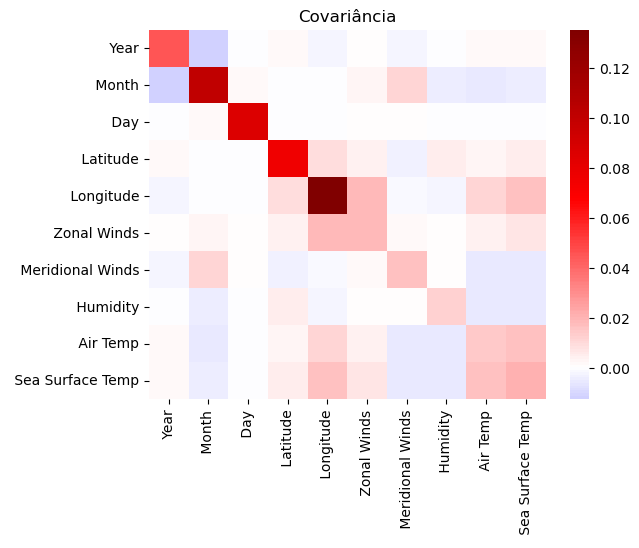

In [7]:
# Criando um mapa de cores dos valores da covariância:

sns.heatmap(df_covariancia, 
    xticklabels=df_covariancia.columns,
    yticklabels=df_covariancia.columns,
    cmap='seismic',
    center = 0)

plt.title('Covariância')
plt.show()

In [8]:
# Matriz de correlação:

df_correlacao = df.corr()

print('Matriz de correlação:')
df_correlacao

Matriz de correlação:


Year     Month       Day   Latitude   Longitude   
 Year              1.000000 -0.186230 -0.016503   0.022339   -0.034951  \
 Month            -0.186230  1.000000  0.013974  -0.001173   -0.008976   
 Day              -0.016503  0.013974  1.000000  -0.001630   -0.002007   
 Latitude          0.022339 -0.001173 -0.001630   1.000000    0.096651   
 Longitude        -0.034951 -0.008976 -0.002007   0.096651    1.000000   
 Zonal Winds       0.026287  0.063149  0.005034   0.117911    0.364256   
 Meridional Winds -0.085108  0.265413  0.005668  -0.092178   -0.024335   
 Humidity         -0.011785 -0.132518 -0.000252   0.158111   -0.042777   
 Air Temp          0.055755 -0.134154 -0.007448   0.076123    0.249050   
 Sea Surface Temp  0.053689 -0.098813 -0.004826   0.125119    0.304027   

                    Zonal Winds   Meridional Winds   Humidity   Air Temp   
 Year                  0.026287          -0.085108  -0.011785   0.055755  \
 Month                 0.063149           0.265413  -0.132518  -0.134154   
 Day                   0.005034           0.005668  -0.000252  -0.007448   
 Latitude              0.117911          -0.092178   0.158111   0.076123   
 Longitude             0.364256          -0.024335  -0.042777   0.249050   
 Zonal Winds           1.000000           0.079763   0.063553   0.233156   
 Meridional Winds      0.079763           1.000000   0.077647  -0.339254   
 Humidity              0.063553           0.077647   1.000000  -0.388059   
 Air Temp              0.233156          -0.339254  -0.388059   1.000000   
 Sea Surface Temp      0.376015          -0.284897  -0.324348   0.940233   

                    Sea Surface Temp  
 Year                       0.053689  
 Month                     -0.098813  
 Day                       -0.004826  
 Latitude                   0.125119  
 Longitude                  0.304027  
 Zonal Winds                0.376015  
 Meridional Winds          -0.284897  
 Humidity                  -0.324348  
 Air Temp                   0.940233  
 Sea Surface Temp           1.000000

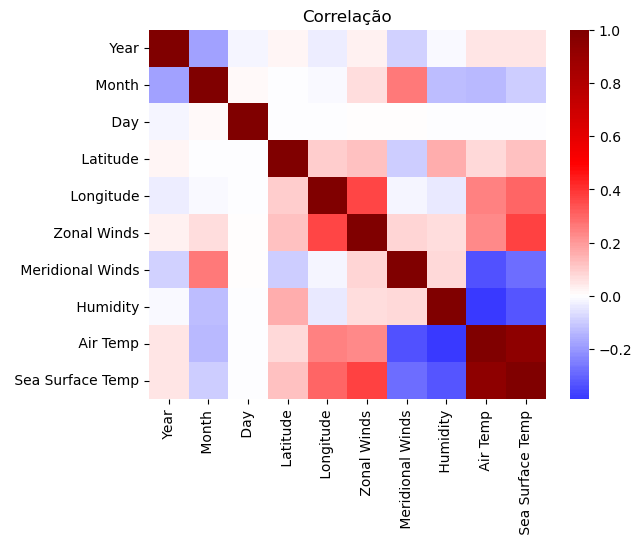

In [9]:
# Criando um mapa de cores dos valores da correlação:

sns.heatmap(df_correlacao, 
        xticklabels=df_correlacao.columns,
        yticklabels=df_correlacao.columns,
        cmap='seismic',
        center = 0)

plt.title('Correlação')
plt.show()

### Tensorização dos dados de entrada

In [10]:
# Criando tensores:

x_treino = torch.tensor(x_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
x_teste = torch.tensor(x_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [11]:
# Checando os dados:

print(x_treino)
print()
print(y_treino)

tensor([[0.4444, 1.0000, 0.3000,  ..., 0.4110, 0.6862, 0.7207],
        [0.8889, 0.4545, 0.1667,  ..., 0.5169, 0.6130, 0.8314],
        [0.7778, 0.9091, 0.0000,  ..., 0.4195, 0.6841, 0.4884],
        ...,
        [0.4444, 0.3636, 0.4333,  ..., 0.3856, 0.7301, 0.6780],
        [0.8889, 0.6364, 0.0000,  ..., 0.3051, 0.6025, 0.7359],
        [0.3333, 0.4545, 0.9000,  ..., 0.4831, 0.6506, 0.5810]])

tensor([[0.8132],
        [0.8444],
        [0.4786],
        ...,
        [0.7121],
        [0.8444],
        [0.5377]])


### Criação da classe da rede neural e definição de outros parâmetros

In [12]:
# Criando a classe da rede neural:

class OS_MENININHOS(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        # Definindo as camadas da rede:
        
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """ Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [13]:
# Criando uma instância da rede:

NUM_DADOS_DE_ENTRADA = x_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 150
NEURONIOS_C2 = 63

minha_redezinha = OS_MENININHOS(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [14]:
# Checando os parâmetros internos:

for p in minha_redezinha.parameters():
    print(p)

Parameter containing:
tensor([[-0.0200,  0.2533, -0.1172,  ...,  0.3172, -0.0320,  0.1671],
        [ 0.2027, -0.1931,  0.2218,  ...,  0.2425, -0.3159, -0.1566],
        [-0.2555,  0.0539,  0.0263,  ...,  0.3183,  0.0053,  0.3043],
        ...,
        [ 0.1283, -0.0271, -0.1063,  ...,  0.1957,  0.3019, -0.1140],
        [ 0.1971,  0.3028, -0.2080,  ..., -0.2438,  0.1090, -0.2726],
        [-0.2833,  0.1549, -0.0808,  ...,  0.0428,  0.3104, -0.3007]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0510, -0.0282, -0.3272,  0.0999,  0.0778, -0.1634,  0.1561, -0.2574,
         0.3269,  0.0793,  0.1195,  0.1044, -0.0726,  0.2780,  0.0963,  0.0415,
         0.2905, -0.0270, -0.2419, -0.0393,  0.1980,  0.3142, -0.1868,  0.2541,
        -0.1445,  0.2178,  0.3323,  0.0171,  0.0784, -0.0606, -0.2480,  0.2016,
        -0.0640,  0.0283,  0.1594,  0.3265, -0.1131, -0.2898, -0.0977,  0.1249,
        -0.1626, -0.0641,  0.1856,  0.0892, -0.1345,  0.2054, -0.2392, -0.1872,
         0.1386

In [15]:
# Primeiro teste de previsão (ruinzinha):

y_prev = minha_redezinha(x_treino)
y_prev

tensor([[-0.0710],
        [-0.0724],
        [-0.0719],
        ...,
        [-0.0522],
        [-0.0865],
        [-0.0497]], grad_fn=<AddmmBackward0>)

In [16]:
# Usando o otimizador (Adam):

TAXA_DE_APRENDIZADO = 0.001

# A função perda será o erro quadrático médio:
fn_perda = nn.MSELoss()

# O otimizador será o Adam, um tipo de descida do gradiente:
otimizador = optim.Adam(minha_redezinha.parameters(), lr=TAXA_DE_APRENDIZADO)

### Treino da rede neural:

In [17]:
# Treinando a rede:

# Colocando ela no "modo treino":
minha_redezinha.train()

NUM_EPOCAS = 1000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # Forward pass:
    y_pred = minha_redezinha(x_treino)

    # Zero grad:
    otimizador.zero_grad()

    # Loss:
    loss = fn_perda(y_pred, y_true)

    # Backpropagation:
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # Exibe o resultado:
    print(epoca, loss.data)

0 tensor(0.6949)
1 tensor(0.5706)
2 tensor(0.4595)
3 tensor(0.3589)
4 tensor(0.2673)
5 tensor(0.1862)
6 tensor(0.1191)
7 tensor(0.0687)
8 tensor(0.0359)
9 tensor(0.0201)
10 tensor(0.0192)
11 tensor(0.0292)
12 tensor(0.0440)
13 tensor(0.0576)
14 tensor(0.0659)
15 tensor(0.0678)
16 tensor(0.0639)
17 tensor(0.0562)
18 tensor(0.0466)
19 tensor(0.0371)
20 tensor(0.0287)
21 tensor(0.0225)
22 tensor(0.0184)
23 tensor(0.0165)
24 tensor(0.0162)
25 tensor(0.0172)
26 tensor(0.0189)
27 tensor(0.0207)
28 tensor(0.0223)
29 tensor(0.0235)
30 tensor(0.0240)
31 tensor(0.0239)
32 tensor(0.0232)
33 tensor(0.0221)
34 tensor(0.0207)
35 tensor(0.0192)
36 tensor(0.0177)
37 tensor(0.0164)
38 tensor(0.0153)
39 tensor(0.0147)
40 tensor(0.0144)
41 tensor(0.0144)
42 tensor(0.0146)
43 tensor(0.0149)
44 tensor(0.0152)
45 tensor(0.0154)
46 tensor(0.0155)
47 tensor(0.0154)
48 tensor(0.0151)
49 tensor(0.0148)
50 tensor(0.0143)
51 tensor(0.0139)
52 tensor(0.0135)
53 tensor(0.0132)
54 tensor(0.0129)
55 tensor(0.0128)
56

In [18]:
# Checando a performance da rede:

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_redezinha(x_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[28.63999986] [28.68050092]
[29.03999988] [29.8067705]
[24.33999998] [24.32690735]
[25.92] [26.46242815]
[26.95000037] [27.16349512]
[29.14999973] [29.44627662]
[23.66999987] [23.86014211]
[28.01000028] [26.89950635]
[26.70000035] [26.53583772]
[28.88999987] [29.27510046]
[28.77000017] [28.15791086]
[30.2999998] [29.99338837]
[29.23999989] [28.90434861]
[23.83000011] [23.93391894]
[29.38000005] [29.32822848]
[29.44999975] [28.11598059]
[29.78000008] [29.6908769]
[28.88999987] [28.55543083]
[28.39999969] [28.28177079]
[25.58999968] [26.89559863]
[29.63999992] [29.65271112]
[28.63000001] [28.77695932]
[30.33000011] [29.80492081]
[25.31999997] [25.43390907]
[27.32000008] [27.93819761]
[27.58999979] [27.24122524]
[29.14999973] [29.86264205]
[24.36000006] [24.93649172]
[28.73999986] [28.33866025]
[28.58000001] [28.74411745]
[27.78999981] [27.36945169]
[29.54999976] [29.89687483]
[29.3899999] [29.41562987]
[28.02999997] [28.4350589]
[25.87] [26.39222166]
[25.02999979] [25.29390585]
[26.11000

### Teste da rede

In [19]:
# Testando a rede:

# Colocando ela no "modo avaliação":
minha_redezinha.eval()

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_redezinha(x_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[26.97000006] [27.04260312]
[28.32999999] [29.15448419]
[28.78999987] [28.64586067]
[29.61000037] [29.63640699]
[27.27999993] [27.39730053]
[23.80000018] [23.36830985]
[27.72999996] [27.89909587]
[28.88000002] [29.33324832]
[29.23000005] [28.03623609]
[25.86000015] [25.36092382]
[29.01000034] [28.66906115]
[30.2999998] [30.16098844]
[29.18999989] [29.28097736]
[29.14999973] [29.70953547]
[28.43999985] [27.862838]
[29.47000021] [29.19942989]
[29.06000034] [29.0187862]
[28.93000003] [28.7584907]
[29.4399999] [29.39174773]
[29.2700002] [29.6892654]
[29.90999963] [29.65005338]
[30.25999965] [29.89152335]
[29.54999976] [29.06936984]
[28.17000014] [29.00586973]
[28.71000032] [28.74754034]
[28.13999983] [27.49065235]
[29.71000038] [28.7606054]
[29.74999977] [29.78918192]
[28.93000003] [29.24552447]
[24.41999991] [24.51932055]
[23.23999992] [24.36877291]
[28.03999982] [28.28292427]
[29.18999989] [28.99790264]
[29.53999991] [28.91193045]
[27.5700001] [26.93026798]
[26.57000004] [26.71216775]
[2

In [20]:
# Medindo a performance com RMSE:

RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.44016276496837453


In [21]:
# Medindo a performance com MAPE:

target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])
MAPE = MeanAbsolutePercentageError()
print(f'Loss do teste: {MAPE(preds, target)}')

Loss do teste: 0.2666666805744171
